## Frequentist vs. Bayesian
In the field of statistical inference, there are two very different, yet mainstream, schools of thought: the frequentist approach, under which the framework of Hypothesis Testing was developed, and the Bayesian approach, which I’d like to introduce to you now.

The difference between these two rival schools can be explained through the different interpretation each gives to the term probability. 

Let’s take a concrete case-in-point: say we are interested in discovering the average height of American citizens nowadays. For a frequentist, this number is unknown but fixed. This is a natural intuitive view, as you can imagine that if you go through all American citizens one by one, measure their height and average the list, you will get the actual number.

However, since you do not have access to all American citizens, you take a sample of, say, a thousand citizens, measure and average their height to produce a point estimate, and then calculate the estimate of your error. The point is that the frequentist looks at the average height as a single unknown number.

A Bayesian statistician, however, would have an entirely different take on the situation. A Bayesian would look at the average height of an American citizen not as a fixed number, but instead as an unknown distribution (you might imagine here a “bell” shaped normal distribution).

For Bayesians, probabilities are fundamentally related to their knowledge about an event. This means, for example, that in a Bayesian view, we can meaningfully talk about the probability that the true conversion rate lies in a given range, and that probability codifies our knowledge of the value based on prior information and/or available data.

For Bayesians, the concept of probability is extended to cover degrees of certainty about any given statement on reality. However, in a strict frequentist view, it is meaningless to talk about the probability of the true conversion rate. For frequentists, the true conversion rate is by definition a single fixed number, and to talk about a probability distribution for a fixed number is mathematically nonsensical.

The same logic applies when seeking to measure the conversion rate of a web-based purchase funnel. Sure, probability can certainly be estimated in a frequentist fashion by measuring the ratio of how many times a conversion was made out of a huge number of trials. But this is not fundamental to the Bayesian, who can stop the test at any point and calculate probabilities from data.

To illustrate the convergence process of the distribution as more data is collected, here is a plot based on test data. Notice how the bell shape becomes sharper (more certain) as data streams in:

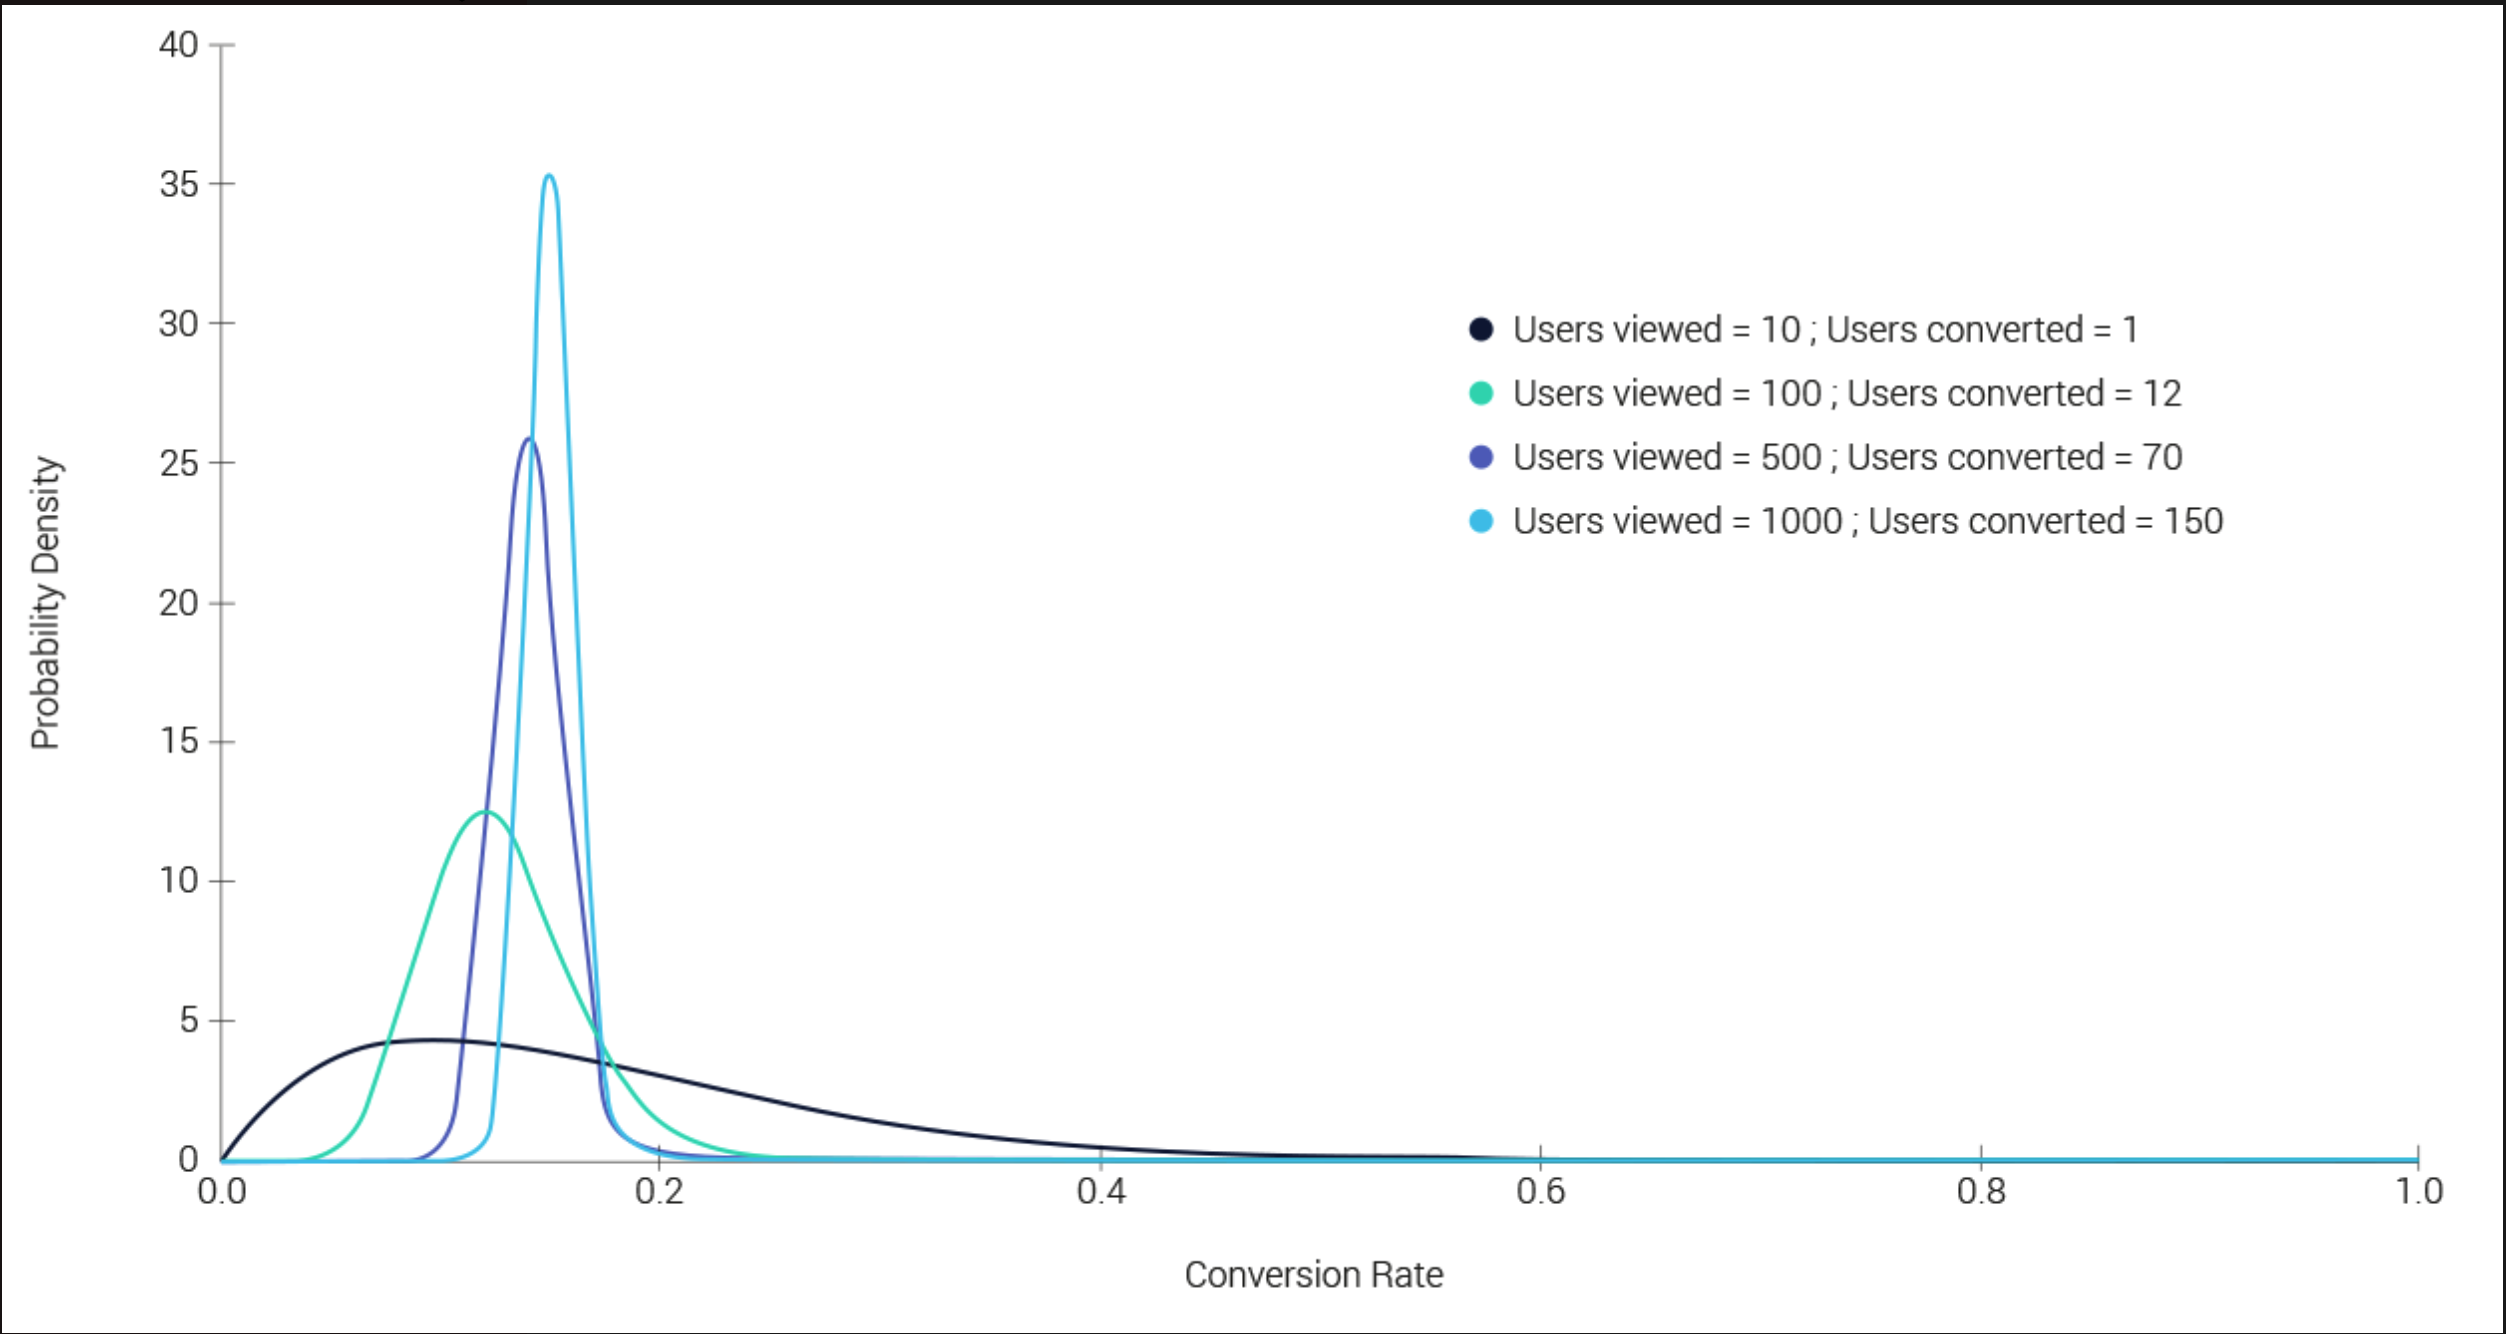

Bayesian approach will tell us the answer to questions like What is the probability that A is better than B? 
(contrast this with the contrived p-value mentioned earlier)

Or, it can give us an estimate to the conversion rate boundaries (interval) in which the true conversion rate falls with 95% probability.

With that all said, let's delve into an example of Bayesian approach to A/B testing!

# Loading of Libraries

In [6]:
# !conda install pymc
from pymc import Uniform, rbernoulli, Bernoulli, MCMC, deterministic


import warnings

# import arviz as az
from matplotlib import pyplot as plt
import numpy as np

# !conda install pymc3
# import pymc3 as pm
# import theano.tensor as tt



# PyMC Package (https://docs.pymc.io/en/v3/)

Here we show how to evaluate the success rate on page A with a Bayesian approach. The goal is to infer the probability of clicking the "Add to Cart" button on page A. We model this probability as a Bernoulli distribution with parameter $p_{A}$:


$P(click|page=A) =
\begin{Bmatrix}
p_{A}  & click=1 \\ 
1 - p_{A} & click=0
\end{Bmatrix}$


So, $p_{A}$ is the parameter indicating the probability of clicking the button on page A. This parameter is unknown and the goal of the experiment is to infer it. Let's assume the number of visitors visiting page A is 23,000. Let that be N.

In [7]:
# True pA (unknown)
pA_true = 0.05

# Number of visitors visiting page A
N = 23000
occurrences = rbernoulli(pA_true, N)

print ('Click-Add-To-Cart:', occurrences.sum())

print ('Observed frequency:', "{:.2%}".format(occurrences.sum() / float(N)))


Click-Add-To-Cart: 1170
Observed frequency: 5.09%


#### Here occurrences indicate how many visitors have actually clicked (converted) the "Add to Cart" button.
And we're going to simulate a scneario where there is a 100K visitors visited the page.

### Defining the Prior $p_A$


In [8]:
pA = Uniform('pA', lower=0, upper=1)
obs = Bernoulli('obs', pA, value=occurrences, observed=True)

The prior of $p_{A}$ to be a uniform distribution. The obs variable is of the Bernoulli distribution and it represents the observations of the click events. The two variables are assigned to Uniform and Bernoulli distributions respectively, which are stochastic variables that are part of PyMC.

In [11]:
# defining a Monte Carlo Markov Chain (MCMC) model
mcmc = MCMC([pA, obs])
# setting the size of the simulations to 200k. Must set the 2nd parameter to a number that is smaller. A good rule of thumb is 1/10th.
mcmc.sample(200000, 20000)
# the resulting posterior distribution is stored in the trace variable
print (mcmc.trace('pA')[:])


 [-----------------100%-----------------] 200000 of 200000 complete in 44.5 sec[0.04974932 0.04974932 0.04974932 ... 0.05462402 0.05107252 0.05226881]


#### As we initialized the MCMC model with pA and obs as the parameters, the sample model will run the Monte Carlo simulations and fit the observed data based on prior definition. The posterior distribution is then stored in an array that can be retrived by the trace property.

### Visualization of the result of the inference

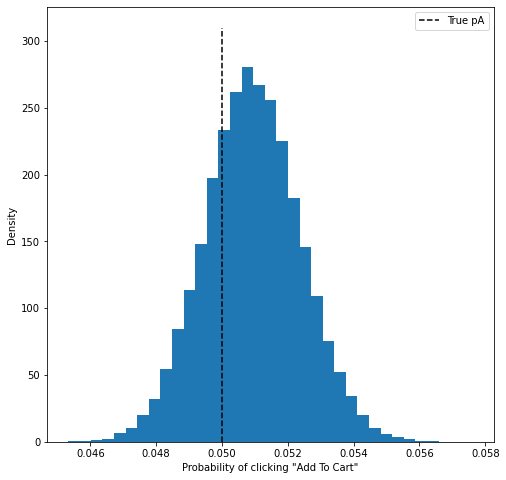

In [12]:
plt.figure(figsize=(8, 8))
plt.hist(mcmc.trace('pA')[:], bins=35, histtype='stepfilled',density=True)
plt.xlabel('Probability of clicking \"Add To Cart\"')
plt.ylabel('Density')
plt.vlines(pA_true, 0, 310, linestyle='--', label='True pA', colors='black')
plt.legend()
plt.show()

## Then we're ready to give out the business insights here, which is what's the probability ($p_{A}$) of clicking the "Add to Cart" button on page A where I am 90% confident within which the $p_{A}$ lies?

In [64]:
pA_samples = mcmc.trace('pA')[:]
# lower bound
lb = np.percentile(pA_samples, 5)
# upper bound
ub = np.percentile(pA_samples, 95)
print ('There is a 90%% probability that pA is between %.3f and %.3f' %(lb, ub))


There is a 90% probability that pA is between 0.047 and 0.052


# Probability of $p_{A} > p_{B}$, i.e., $p_{A} - p_{B} $ is greater than 0

Observed frequency:
 A 5.47%
Observed frequency:
 B 5.22%
 [-----------------100%-----------------] 23000 of 23000 complete in 10.2 sec

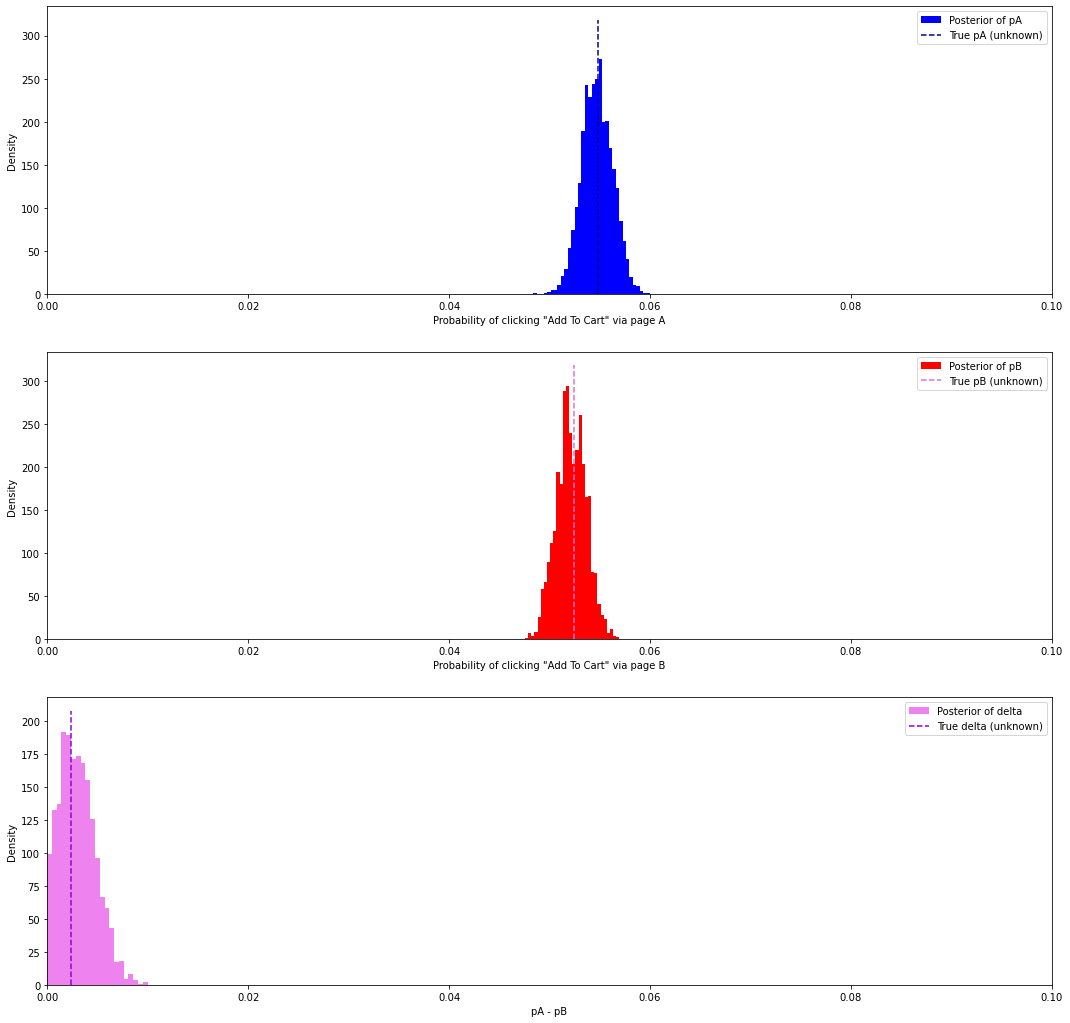

In [41]:
# Assuming pA_true is 5.48% while pB_true = 5.24%
pA_true = 0.0548
pB_true = 0.0524
# Assuming number of visitors visiting page A, N_A, is 23,000 and N_B is 23,001
N_A = 23000
N_B = 23001

occurrences_A = rbernoulli(pA_true, N_A)
occurrences_B = rbernoulli(pB_true, N_B)

print ('Observed frequency:\n', 'A', "{:.2%}".format(occurrences_A.sum() / float(N_A)))
print ('Observed frequency:\n', 'B', "{:.2%}".format(occurrences_B.sum() / float(N_B)))
pA = Uniform('pA', lower=0, upper=1)
pB = Uniform('pB', lower=0, upper=1)

# Ensures the output of this function is deterministic. A program is deterministic if you get the same result and 
# behavior every time you run it. 
@deterministic
def delta(pA=pA, pB=pB):
    return pA - pB

obs_A = Bernoulli('obs_A', pA, value=occurrences_A, observed=True)
obs_B = Bernoulli('obs_B', pB, value=occurrences_B, observed=True)

mcmc = MCMC([pA, pB, obs_A, obs_B, delta])
mcmc.sample(23000,2300)

pA_samples = mcmc.trace('pA')[:]
pB_samples = mcmc.trace('pB')[:]
delta_samples = mcmc.trace('delta')[:]

plt.figure(figsize=(18, 18))
plt.subplot(3,1,1)
plt.xlim(0, 0.1)
plt.hist(pA_samples, bins=35, histtype='stepfilled', density=True,
color='blue', label='Posterior of pA')
plt.vlines(pA_true, 0, 318, linestyle='--', label='True pA (unknown)', colors='darkblue')
plt.xlabel('Probability of clicking \"Add To Cart\" via page A')
plt.ylabel('Density')
plt.legend()
plt.subplot(3,1,2)
plt.xlim(0, 0.1)
plt.hist(pB_samples, bins=35, histtype='stepfilled', density=True,
color='red', label='Posterior of pB')
plt.vlines(pB_true, 0, 318, linestyle='--', label='True pB (unknown)', colors='orchid')
plt.xlabel('Probability of clicking \"Add To Cart\" via page B')
plt.ylabel('Density')
plt.legend()
plt.subplot(3,1,3)
plt.xlim(0, 0.1)
plt.hist(delta_samples, bins=35, histtype='stepfilled', density=True,
color='violet', label='Posterior of delta')
plt.vlines(pA_true - pB_true, 0, 208, linestyle='--', label='True delta (unknown)', colors='darkviolet')
plt.xlabel('pA - pB')
plt.ylabel('Density')
plt.legend()
plt.show()


In [42]:
print ('Probability that p_A > p_B:', "{:.2%}".format((delta_samples > 0).mean()))


Probability that p_A > p_B: 88.61%


# Conclusion

####  We're confident that probability of having a higher conversion rate in page A than page B as we see the probability of such an event happening is greater than 50%

# References

1. Frequentist vs. Bayesian approach in A/B testing (https://www.dynamicyield.com/lesson/bayesian-testing/)

2. Bayesian A/B Testing in Python (https://www.marcosantoni.com/2016/05/15/bayesian-ab-testing-in-python.html)